<h1 align = 'center'>Guessing Games</h1>
<h3 align = 'center'>machine learning, one step at a time</h3>
<h3 align = 'center'>Step 5. Going Uphill</h3>

#### 5. Let's try to play the dice game.

Remember: these are the rules:
<ul>
<li>the maximum score is 20
<li>roll a pair of dice, add them up, that's your score
<li>decide if you want to roll **both dice** again... if you do, add the roll to your score
<li>get as close as you can to a total of 20...
<li>but if you go over 20, your score is zero.
</ul>

Here is our function to roll a specified number of dice:

In [2]:
import random

def roll_dice(number_of_dice):
    
    sum = 0
    
    for i in range(0, number_of_dice):
        sum += random.randrange(6)+1     # randrange is 0 through 5, so add 1 to get a six-sided die roll
    return sum

roll_dice(2)

8

The key to the game is deciding when to roll (again) without going over the maximum score.

So for any score, the program needs to guess whether rolling again is a good idea.

In [3]:
def play(threshold):                  # the 'threshold' is the score above which the player stops rolling
    
    total_score = roll_dice(2)        # start by rolling two dice
    
    while total_score < threshold:    # if the score under the threshold...
        total_score += roll_dice(2)   # roll again, and add to score
        
    if total_score <= 20:
        return total_score            # if total is 20 or less, that's your score...
    else:
        return 0                      #  but if you go over 20, your score is zero.

Just for fun, let's say that we decide to roll if our total is less than 17, and we play 10 times:

In [4]:
for i in range(0,10):
    print(play(17))     # play the game once; roll again if total is less than 17

0
0
19
17
19
20
17
0
17
0


There's a pretty good chance that we won some, and we lost some. It's probably not the best way to play... but hey, we did not put in a lot of effort... we just picked the threshold of 17 arbitrarily.

We could try a lower threshold, so we never go over a total of 20:

In [5]:
for i in range(0,10):
    print(play(8))     # play the game once; roll again if total is less than 8

14
11
8
13
15
12
10
8
14
14


Or a higher threshold, so we almost always go over a total of 20:

In [6]:
for i in range(0,10):
    print(play(19))     # play the game once; roll again if total is less than 19

0
20
0
0
19
20
20
0
0
0


But we really can't just guess the optimum threshold.

**How could we use machine learning to find the optimum threshold?**

For starters, let's try to understand the relationship between the threshold and the resulting score, using data visualization:

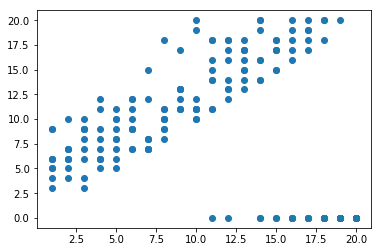

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

thresholds = []
scores = []
    
for threshold in range(1,21):          # for every threshold from 1 to 20...
    for i in range(1,10):              # play the game 10 times, using that threshold...
        thresholds.append(threshold)   # and record the threshold and the score
        scores.append(play(threshold))

plt.plot(thresholds,scores,'o')        # the same score plots on top of itself, so not the best graph...

(Take a good look at the dots)

Those dots suggest that higher thresholds lead to higher scores, but if the threshold is too high, you might just score zero

How about plotting each threshold versus its average score?

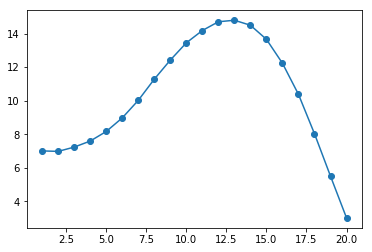

In [8]:
thresholds = []
scores = []
tries = 10000

def average_score(threshold, tries):
    total_score = 0
    for i in range(0,tries):
        total_score += play(threshold)            # add up all the scores...
    return total_score / tries                    # ...then divide by the number of games played
        
for threshold in range(1,21):                     # make lists for thresholds and total scores
    thresholds.append(threshold)
    scores.append(0)

for threshold in range(1,21):
    scores[threshold-1] = average_score(threshold,tries)  # accumulate the total score in list of scores

plt.plot(thresholds,scores,'o-')

Looks like the highest average score is around 14 or 15 total points, using a threshold of around 12 or 13.

Could a program find the optimum threshold to get the highest average score, if we set it up to guess, then learn from its mistakes?

(if you guessed 'that's the point of the lesson', you would be right)

Let's imagine we know nothing about the game, and we start by guessing a threshold of 7:

In [9]:
average_score(7,10000)

10.038

The average score is somewhere around 10... how do we judge if that is a good score?

Or: **where do we get a hint, when we need one?**

Let's manufacture our own hint. Try moving one space to the left of 7, and then one space to the right of 7, and seeing how those results compare to each other:

In [10]:
left = average_score(7 - 1, 100000)
right = average_score(7 + 1, 100000)
print(left, right)

8.969 11.28104


We created a **hint**: it looks like moving to the left makes things worse (the score goes down), while moving to the right makes things better (the score goes up). In terms of a graph, **the slope is upward** for a threshold of 7:

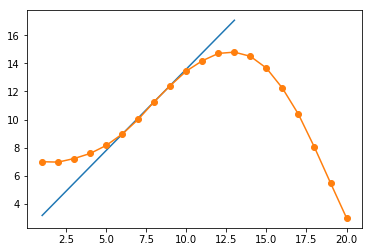

In [12]:
# feel free to ignore these details... we are drawing a line, and aligning it with the prior results
m = (right - left)/2                     # find the slope
b = left-(m*7)                           # find the intercept
x = [1,13]                               # pick endpoints
y = [m * (xi+1) + b for xi in x]         # compute y values (the +1 is to align with prior results)
plt.plot(x,y,'-',thresholds,scores,'o-') # plot the line along with the prior results

To make the score higher, starting with a threshold of 7... go up the hill! (ie, move to the right).

How about a threshold of 16?

It's the same drill:

In [13]:
left1 = average_score(16 - 1, 100000)
right1 = average_score(16 + 1, 100000)
print(left1, right1)

13.66376 10.32258


This time, the slope is **downward**:

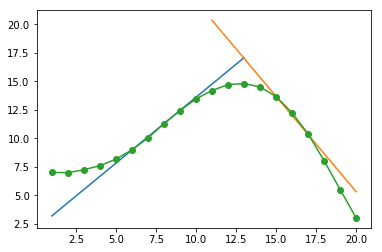

In [14]:
m1 = (right1 - left1)/2                 # find the slope
b1 = left1-(m1*16)                      # find the intercept
x1 = [11,20]                            # pick endpoints
y1 = [m1 * (xi+1) + b1 for xi in x1]    # compute y values (the +1 is to align with prior results)
plt.plot(x,y,'-',x1,y1,'-',thresholds,scores,'o-')

It stands to reason that we can manufacture hints anywhere along the curve, and use those hints to tell us which way to go. If the slope is positive, move to the right (increase the threshold in proportion to the slope). If the slope is negative, move to the left (decrease the threshold in proportion to the slope). Move a little at a time, and when the slope stops changing (more or less), that's the best threshold:

In [15]:
def get_slope(threshold):
    return (average_score(threshold+1,10000)-average_score(threshold-1,10000))/2

def get_threshold_for_maximum_score(threshold):
    m = 999
    while abs(m) > 0.10:             # while the slope is not close to zero
        m = get_slope(threshold)     # compute the slope
        threshold += m * 0.05        # update the threshold by using the slope as a hint
    return threshold

wild_guess = random.random() * 18 + 2
print(get_threshold_for_maximum_score(wild_guess))

12.972831514399596


I get an optimum threshold of around 12 or 13, and it takes about 20 or 30 seconds to run.

<hr>
***Exercises***<p>
    **(1) Write a function called *two_player(threshold_a, threshold_b)* that allows *player_a* to play against *player_b*, where each player has its own threshold, and time games go to *player_b*. The function should return true if player_a wins, and false if player_b wings.**

In [ ]:
def two_player(threshold_a, threshold_b):
    # your code goes here... play a against b, and return 'true' if a wins
    # remember: if the score is tied, then b wins

two_player(15,15)

**(2) Write a function *play_games(threshold_a, threshold_b, number_of_games)* that plays one player against the other, specifying three parameters:<ol><li>the threshold for *player_a*<li>the threshold for *player_b*<li>the number of games to play (aka 'tries')</ol><p>Return *player_a's* winning percentage.**

In [ ]:
def play_games(threshold_a, threshold_b, tries):
    # your code goes here... play a against b, using the specified thresholds, for the specified number of games

play_games(10,10,1000)    # here is a test... player_a will probably win less than 50% of the games

**(3) Create a 3-D surface plot using your function (just execute the code, below, making sure it calls your function), as ask yourself, what does the shape indicate?**

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def play_a_versus_b(tries):
    x = np.zeros((20,20))
    y = np.zeros((20,20))
    z = np.zeros((20,20))
    for a in range(0,20):
        for b in range(0,20):
            x[a,b] = a
            y[a,b] = b
            z[a,b] = play_games(a,b,tries)  # call your function here!
    return x,y,z

x,y,z = play_a_versus_b(1000)               # play 1,000 times per cell (total = 20 x 20 x 1000)

# here is how you make a 3-D wireframe plot
# see https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z)
plt.show()
